# TensorFlow Regression Example

## Creating Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 1 Million Points
x_data = np.linspace(0.0,10.0,1000000)

In [3]:
noise = np.random.randn(len(x_data))

In [4]:
# y = mx + b + noise_levels
b = 5

y_true =  (0.5 * x_data ) + 5 + noise

In [5]:
my_data = pd.concat([pd.DataFrame(data=x_data,columns=['X Data']),pd.DataFrame(data=y_true,columns=['Y'])],axis=1)

In [6]:
my_data.head()

,X Data,Y
0,0.00000,5.648286
1,0.00001,4.458049
2,0.00002,5.367125
3,0.00003,4.082832
4,0.00004,5.428850


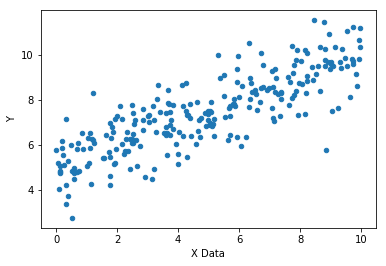

In [7]:
my_data.sample(n=250).plot(kind='scatter',x='X Data',y='Y')

# TensorFlow
## Batch Size

We will take the data in batches (1,000,000 points is a lot to pass in at once)

In [8]:
import tensorflow as tf

In [9]:
# Random 10 points to grab
batch_size = 8

** Variables **

In [10]:
m = tf.Variable(0.5)
b = tf.Variable(1.0)

** Placeholders **

In [11]:
xph = tf.placeholder(tf.float32,[batch_size])
yph = tf.placeholder(tf.float32,[batch_size])

** Graph **

In [12]:
y_model = m*xph + b

** Loss Function **

In [13]:
error = tf.reduce_sum(tf.square(yph-y_model))

** Optimizer **

In [14]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
train = optimizer.minimize(error)

** Initialize Variables **

In [15]:
init = tf.global_variables_initializer()

### Session

In [16]:
with tf.Session() as sess:
    
    sess.run(init)
    
    batches = 1000
    
    for i in range(batches):
        
        rand_ind = np.random.randint(len(x_data),size=batch_size)
        
        feed = {xph:x_data[rand_ind],yph:y_true[rand_ind]}
        
        sess.run(train,feed_dict=feed)
        
    model_m,model_b = sess.run([m,b])

In [17]:
model_m

0.5646035

In [18]:
model_b

4.9254436

### Results

In [19]:
y_hat = x_data * model_m + model_b

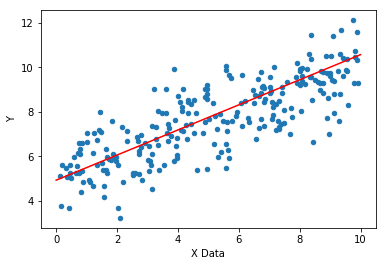

In [20]:
my_data.sample(n=250).plot(kind='scatter',x='X Data',y='Y')
plt.plot(x_data,y_hat,'r')

## tf.estimator API

Much simpler API for basic tasks like regression! We'll talk about more abstractions like TF-Slim later on.

In [38]:
feat_cols = [tf.feature_column.numeric_column('x',shape=[1])]

[_NumericColumn(key='x', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

In [22]:
estimator = tf.estimator.LinearRegressor(feature_columns=feat_cols)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/28/6fl1s6897q17ww4ypjgd5p540000gn/T/tmpvdf9muue', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x182596a668>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


### Train Test Split

We haven't actually performed a train test split yet! So let's do that on our data now and perform a more realistic version of a Regression Task

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
x_train, x_eval, y_train, y_eval = train_test_split(x_data,y_true,test_size=0.3, random_state = 101)

In [25]:
print(x_train.shape)
print(y_train.shape)

print(x_eval.shape)
print(y_eval.shape)

(700000,)
(700000,)
(300000,)
(300000,)


### Set up Estimator Inputs

In [26]:
# Can also do .pandas_input_fn
input_func = tf.estimator.inputs.numpy_input_fn({'x':x_train},y_train,batch_size=4,num_epochs=None,shuffle=True)

In [27]:
train_input_func = tf.estimator.inputs.numpy_input_fn({'x':x_train},y_train,batch_size=4,num_epochs=1000,shuffle=False)

In [28]:
eval_input_func = tf.estimator.inputs.numpy_input_fn({'x':x_eval},y_eval,batch_size=4,num_epochs=1000,shuffle=False)

### Train the Estimator

In [29]:
estimator.train(input_fn=input_func,steps=1000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/28/6fl1s6897q17ww4ypjgd5p540000gn/T/tmpvdf9muue/model.ckpt.
INFO:tensorflow:loss = 142.55505, step = 1
INFO:tensorflow:global_step/sec: 799.34
INFO:tensorflow:loss = 5.514703, step = 101 (0.127 sec)
INFO:tensorflow:global_step/sec: 988.067
INFO:tensorflow:loss = 9.599696, step = 201 (0.101 sec)
INFO:tensorflow:global_step/sec: 1056.33
INFO:tensorflow:loss = 5.8204536, step = 301 (0.095 sec)
INFO:tensorflow:global_step/sec: 1096.88
INFO:tensorflow:loss = 3.0331802, step = 401 (0.091 sec)
INFO:tensorflow:global_step/sec: 1103.64
INFO:tensorflow:loss = 0.7661421, step = 501 (0.091 sec)
INFO:tensorflow:global_step/sec: 1099.87
INFO:tensorflow:loss = 17.06191, step = 601 (0.090 sec)
INFO:tensorflow:g

### Evaluation

In [30]:
train_metrics = estimator.evaluate(input_fn=train_input_func,steps=1000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-28-06:06:02
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/28/6fl1s6897q17ww4ypjgd5p540000gn/T/tmpvdf9muue/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [100/1000]
INFO:tensorflow:Evaluation [200/1000]
INFO:tensorflow:Evaluation [300/1000]
INFO:tensorflow:Evaluation [400/1000]
INFO:tensorflow:Evaluation [500/1000]
INFO:tensorflow:Evaluation [600/1000]
INFO:tensorflow:Evaluation [700/1000]
INFO:tensorflow:Evaluation [800/1000]
INFO:tensorflow:Evaluation [900/1000]
INFO:tensorflow:Evaluation [1000/1000]
INFO:tensorflow:Finished evaluation at 2018-05-28-06:06:03
INFO:tensorflow:Saving dict for global step 1000: average_loss = 1.1155709, global_step = 1000, loss = 4.4622836


In [31]:
eval_metrics = estimator.evaluate(input_fn=eval_input_func,steps=1000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-28-06:06:03
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/28/6fl1s6897q17ww4ypjgd5p540000gn/T/tmpvdf9muue/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [100/1000]
INFO:tensorflow:Evaluation [200/1000]
INFO:tensorflow:Evaluation [300/1000]
INFO:tensorflow:Evaluation [400/1000]
INFO:tensorflow:Evaluation [500/1000]
INFO:tensorflow:Evaluation [600/1000]
INFO:tensorflow:Evaluation [700/1000]
INFO:tensorflow:Evaluation [800/1000]
INFO:tensorflow:Evaluation [900/1000]
INFO:tensorflow:Evaluation [1000/1000]
INFO:tensorflow:Finished evaluation at 2018-05-28-06:06:04
INFO:tensorflow:Saving dict for global step 1000: average_loss = 1.1162995, global_step = 1000, loss = 4.465198


In [32]:
print("train metrics: {}".format(train_metrics))
print("eval metrics: {}".format(eval_metrics))

train metrics: {'average_loss': 1.1155709, 'loss': 4.4622836, 'global_step': 1000}
eval metrics: {'average_loss': 1.1162995, 'loss': 4.465198, 'global_step': 1000}


### Predictions

In [33]:
input_fn_predict = tf.estimator.inputs.numpy_input_fn({'x':np.linspace(0,10,10)},shuffle=False)

In [34]:
list(estimator.predict(input_fn=input_fn_predict))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/28/6fl1s6897q17ww4ypjgd5p540000gn/T/tmpvdf9muue/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


[{'predictions': array([4.3543606], dtype=float32)},
 {'predictions': array([5.031957], dtype=float32)},
 {'predictions': array([5.7095537], dtype=float32)},
 {'predictions': array([6.38715], dtype=float32)},
 {'predictions': array([7.064747], dtype=float32)},
 {'predictions': array([7.742343], dtype=float32)},
 {'predictions': array([8.419939], dtype=float32)},
 {'predictions': array([9.097536], dtype=float32)},
 {'predictions': array([9.775133], dtype=float32)},
 {'predictions': array([10.452729], dtype=float32)}]

In [35]:
predictions = []# np.array([])
for x in estimator.predict(input_fn=input_fn_predict):
    predictions.append(x['predictions'])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/28/6fl1s6897q17ww4ypjgd5p540000gn/T/tmpvdf9muue/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [36]:
predictions

[array([4.3543606], dtype=float32),
 array([5.031957], dtype=float32),
 array([5.7095537], dtype=float32),
 array([6.38715], dtype=float32),
 array([7.064747], dtype=float32),
 array([7.742343], dtype=float32),
 array([8.419939], dtype=float32),
 array([9.097536], dtype=float32),
 array([9.775133], dtype=float32),
 array([10.452729], dtype=float32)]

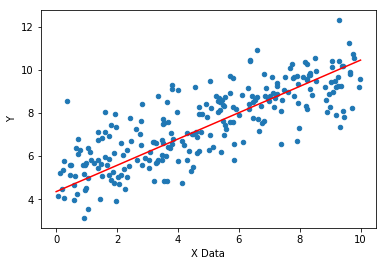

In [37]:
my_data.sample(n=250).plot(kind='scatter',x='X Data',y='Y')
plt.plot(np.linspace(0,10,10),predictions,'r')

# Great Job!